# The toy regression problem

## IMPORTS

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

Let us generate a toy dataset $(X_i,Y_i)_{i\in[N]}$ iid $\sim (X,Y)$, with $(X,Y) \in \mathbb{R}^2$, $X ↪ \mathcal{U}([-3,3])$, $Y|X ↪ \mathcal{N}(\mu(X),\sigma^2(X))$

Our objective will be, for any realization $(X',Y') \sim (X,Y)$, to predict given $X'$ the most likely value of $Y'$, and the uncertainty around that prediction

To do so, let us first build our dataset

In [13]:
theoretical_sigma = lambda x:0.15/(1+torch.exp(-x))
theoretical_mu = lambda x:torch.sin(x)

n_samples_train = 1000

x_values_train = (torch.rand(n_samples_train)*6-3)
y_values_train = torch.randn(n_samples_train) * theoretical_sigma(x_values_train) + theoretical_mu(x_values_train)

print(x_values_train.shape)
print(y_values_train.shape)

train_dataset = TensorDataset(x_values_train.unsqueeze(-1), y_values_train.unsqueeze(-1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

n_samples_test = 200

x_values_test = torch.linspace(-6,6,n_samples_test)

torch.Size([1000])
torch.Size([1000])


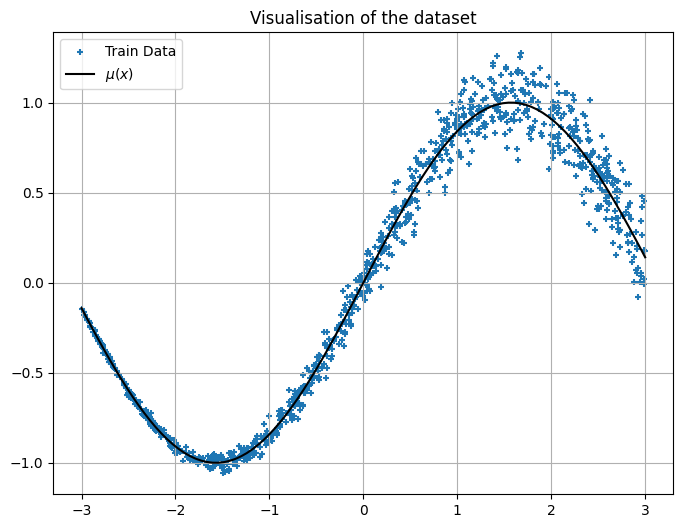

In [14]:
plt.figure(figsize=(8,6))
plt.title("Visualisation of the dataset")

t = torch.linspace(-3,3,100)

plt.scatter(x_values_train,y_values_train,marker="+",s=15,label="Train Data")
plt.plot(t,theoretical_mu(t),label="$\mu(x)$",color='black')
plt.legend()
plt.grid()

plt.show()

## An ensembling model

The objective of this section is to implement uncertainty quantification by *ensembling*. The idea consists in creating $M$ identical NNs, successively training them, and use the mean and variance estimates to predict uncertainty

First, let us create the NN class corresponding to our problem

This NN is composed of two parallel MLPs with 3 layers of width 10. For any $x \in [-3,3]$, the first MLP outputs an estimation of $\mu(x)$, and the second MLP an estimation of $\log (\sigma^2(x))$

In [15]:
class ToyRegressionModel(nn.Module):

  """
  This model contains two parallel MLPs of given hidden size (default 10), and given layer number (default 3)
  The first mlp outputs an estimator of the mean, the second an estimator of the variance
  """

  def __init__(self,hidden_size=10,layer_number=3):

    super().__init__()
    self.hidden_size = hidden_size
    self.layer_number = layer_number

    self.mlp1 = nn.Sequential(
        nn.Linear(1,hidden_size),
        nn.ReLU()
    )

    self.mlp2 = nn.Sequential(
        nn.Linear(1,hidden_size),
        nn.ReLU()
    )

    for i in range(1,layer_number-1):
      self.mlp1.append(nn.Linear(hidden_size,hidden_size))
      self.mlp1.append(nn.ReLU())

      self.mlp2.append(nn.Linear(hidden_size,hidden_size))
      self.mlp2.append(nn.ReLU())

    self.mlp1.append(nn.Linear(hidden_size,1))
    self.mlp2.append(nn.Linear(hidden_size,1))

  def forward(self,x):
    return torch.cat((self.mlp1(x),self.mlp2(x)),axis=1)



Now, let us train `M` instances of this MLP on our training dataset.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

M = 16
n_epochs = 150

nn_list = [ToyRegressionModel().to(device) for _ in range(M)]

# training loop

for i in range(M):

  model = nn_list[i]
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  model.train()

  print(f"Starting to train model {i}")

  for e in range(1,n_epochs+1):
    for inputs,targets in train_loader:

      inputs, targets = inputs.to(device),targets.to(device)
      output = nn_list[i](inputs)
      mean = output[:,0].unsqueeze(-1)
      log_var = output[:,1].unsqueeze(-1)

      loss = torch.mean(torch.pow(targets - mean,2)*torch.exp(-log_var) + log_var)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()



Starting to train model 0
Starting to train model 1
Starting to train model 2
Starting to train model 3
Starting to train model 4
Starting to train model 5
Starting to train model 6
Starting to train model 7
Starting to train model 8
Starting to train model 9
Starting to train model 10
Starting to train model 11
Starting to train model 12
Starting to train model 13
Starting to train model 14
Starting to train model 15


Now, let us evaluate our prediction on a test dataset : $(X_i)_{i \in [1000]}$ being an uniform subdivision of [-6,6].

For any $i \in [1000]$ and $j \in [M]$, let us denote by $\hat{\mu}_j(X_i),\hat{\sigma^2}_j(X_i)$ the mean and variance predicted by the $j$-th model with an input equal to $X_i$

The overall predictor of $\mu(X_i)$ will naturally be
$$\frac{1}{N} \sum_{j=1}^{M} \hat{\mu}_j(X_i) := \mathrm{Avg}(\hat{\mu}_j(X_i))_{i \in [M]} $$

And the overall predictor of $\sigma^2(X_i)$ will be
$$\mathrm{Avg}(\hat{\sigma^2}_j(X_i))_{i \in [M]} + \mathrm{Var}(\hat{\mu}_j(X_i))_{i \in [M]} $$

The latter formula contains two terms : the first one corresponds to *aleatoric uncertainty*, coming from the dependecy between $Y'$ and $X'$. The second one corresponds to *epistemic uncertainty*, coming from estimation error on the model parameters

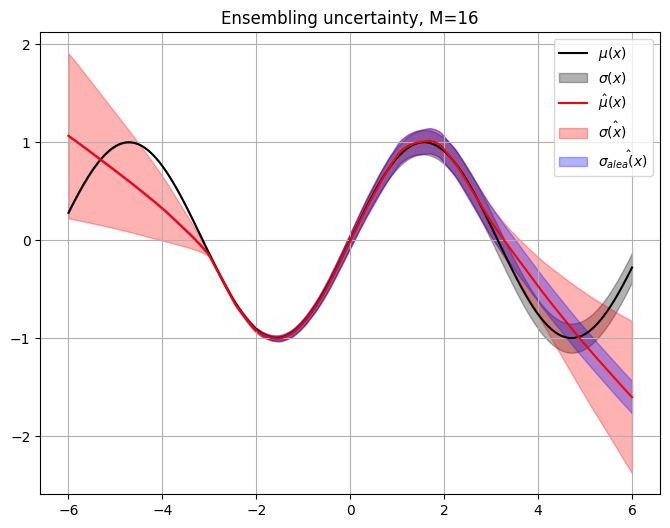

In [17]:
n_test = 1000
x_values_test = torch.linspace(-6,6,n_test)

output_list = []

for i in range(M):
  nn_list[i].eval()
  output_list.append(nn_list[i](x_values_test.unsqueeze(-1).to(device)).detach().cpu())

test_output = torch.stack(output_list,axis=2)
test_means = test_output[:,0,:]
test_vars = torch.exp(test_output[:,1,:])

test_mean = torch.mean(test_means,axis=1)
test_alea_var = torch.mean(test_vars,axis=1)
test_epi_var = torch.var(test_means,axis=1)
test_std = torch.sqrt(test_alea_var+test_epi_var)
test_alea_std = torch.sqrt(test_alea_var)

plt.figure(figsize=(8,6))
plt.title(f"Ensembling uncertainty, M={M}")

theo_mean = theoretical_mu(x_values_test)
theo_std = theoretical_sigma(x_values_test)

plt.plot(x_values_test,theo_mean,label="$\mu(x)$",color='black')
plt.fill_between(x_values_test, (theo_mean - theo_std), (theo_mean + theo_std),
                 color='black', alpha=0.3,label="$\sigma(x)$")

plt.plot(x_values_test,test_mean,label="$\hat{\mu}(x)$",color='r')
plt.fill_between(x_values_test.squeeze(), (test_mean - test_std), (test_mean + test_std),
                 color='red', alpha=0.3,label="$\hat{\sigma(x)}$")
plt.fill_between(x_values_test.squeeze(), (test_mean - test_alea_std), (test_mean + test_alea_std),
                 color='blue', alpha=0.3,label="$\hat{\sigma_{alea}(x)}$")
plt.legend()
plt.grid()

plt.show()

## A MC-Dropout model

The objective of this section is to implement uncertainty quantification by *MC-Dropout*. The idea consists in creating a few (less than $M$) identical NNs. These NNs contain dropout layers after some of their ReLUs, meaning that the output of the NN is random.

The sequence of mean and variance estimates is generated by running inputs multiple times for each model

Let us create the NN class corresponding to this problem

In [18]:
class DropoutToyRegressionModel(nn.Module):

  """
  This model contains two parallel MLPs of given hidden size (default 10), and given layer number (default 3)
  The first mlp outputs an estimator of the mean, the second an estimator of the variance
  In addition, we implement dropout in the model.
  """

  def __init__(self,hidden_size=10,layer_number=3):

    super().__init__()
    self.hidden_size = hidden_size
    self.layer_number = layer_number
    # set model.dropout_layers.train() at inference
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.2)

    self.mlp1 = nn.Sequential(
        nn.Linear(1,hidden_size),
        self.dropout1,
        nn.ReLU()
    )

    self.mlp2 = nn.Sequential(
        nn.Linear(1,hidden_size),
        self.dropout2,
        nn.ReLU()
    )

    for i in range(1,layer_number-1):
      self.mlp1.append(nn.Linear(hidden_size,hidden_size))
      self.mlp1.append(nn.ReLU())

      self.mlp2.append(nn.Linear(hidden_size,hidden_size))
      self.mlp2.append(nn.ReLU())

    self.mlp1.append(nn.Linear(hidden_size,1))
    self.mlp2.append(nn.Linear(hidden_size,1))

  def forward(self,x):
    return torch.cat((self.mlp1(x),self.mlp2(x)),axis=1)


And now, let us train $M = 10$ instances of our dropout NN

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

M = 10
n_epochs = 150

nn_list_2 = [DropoutToyRegressionModel().to(device) for _ in range(M)]

# training loop

for i in range(M):

  model = nn_list_2[i]
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  model.train()

  print(f"Starting to train model {i}")

  for e in range(1,n_epochs+1):
    for inputs,targets in train_loader:

      inputs, targets = inputs.to(device),targets.to(device)
      output = model(inputs)
      mean = output[:,0].unsqueeze(-1)
      log_var = output[:,1].unsqueeze(-1)

      loss = torch.mean(torch.pow(targets - mean,2)*torch.exp(-log_var) + log_var)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

Starting to train model 0
Starting to train model 1
Starting to train model 2
Starting to train model 3
Starting to train model 4
Starting to train model 5
Starting to train model 6
Starting to train model 7
Starting to train model 8
Starting to train model 9


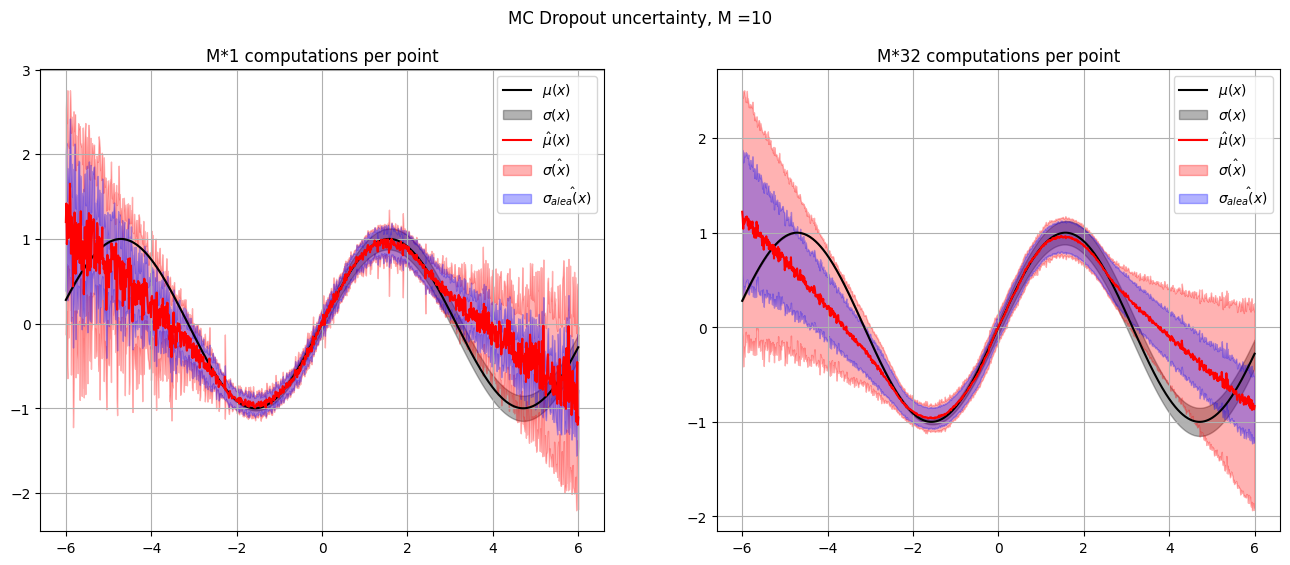

In [23]:
n_test = 1000
x_values_test = torch.linspace(-6,6,n_test)

output_list_1 = []
output_list_32 = []
for i in range(M):
  nn_list_2[i].eval()
  nn_list_2[i].dropout1.train() # IMPORTANT, ensure dropout at inference
  nn_list_2[i].dropout2.train()
  output_list_1.append(nn_list_2[i](x_values_test.unsqueeze(-1).to(device)).detach().cpu())
  for _ in range(32):
    output_list_32.append(nn_list_2[i](x_values_test.unsqueeze(-1).to(device)).detach().cpu())

outputs_list = [output_list_1,output_list_32]
title_list=["M*1 computations per point","M*32 computations per point"]

plt.figure(figsize=(16,6))
plt.suptitle(f"MC Dropout uncertainty, M ={M}")

for i in range(2):

  test_output = torch.stack(outputs_list[i],axis=2)
  test_means = test_output[:,0,:]
  test_vars= torch.exp(test_output[:,1,:])

  test_mean = torch.mean(test_means,axis=1)
  test_alea_var = torch.mean(test_vars,axis=1)
  test_epi_var = torch.var(test_means,axis=1)
  test_std = torch.sqrt(test_alea_var+test_epi_var)
  test_alea_std = torch.sqrt(test_alea_var)

  theo_mean = theoretical_mu(x_values_test)
  theo_std = theoretical_sigma(x_values_test)

  plt.subplot(1,2,i+1)
  plt.title(title_list[i])
  plt.plot(x_values_test,theo_mean,label="$\mu(x)$",color='black')
  plt.fill_between(x_values_test, (theo_mean - theo_std), (theo_mean + theo_std),
                  color='black', alpha=0.3,label="$\sigma(x)$")

  plt.plot(x_values_test,test_mean,label="$\hat{\mu}(x)$",color='r')
  plt.fill_between(x_values_test.squeeze(), (test_mean - test_std), (test_mean + test_std),
                  color='red', alpha=0.3,label="$\hat{\sigma(x)}$")
  plt.fill_between(x_values_test.squeeze(), (test_mean - test_alea_std), (test_mean + test_alea_std),
                  color='blue', alpha=0.3,label="$\hat{\sigma_{alea}(x)}$")
  plt.legend()
  plt.grid()

plt.show()

This graph shows us that even if the MC-Dropout network performs poorly if evaluated a single time, the results improve if we run multiple (here 32) times the network for each input